In [2]:
import numpy as np
from collections import defaultdict

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

%matplotlib inline
plt.rcParams['figure.dpi'] = 200

# Create connectivity matrices

First we must create the connectivity matrix between neurons. 
In the following cell, we make a fully-connected network using the following steps:
1. Create a uniformly random 1000x1000 matrix 
2. Define 20% of the neurons to be inhibitory.
3. Change all connections for inhibitory neurons multiplying by -1. 
4. Let average connection be 1/n_neurons by dividing all weights. 
5. Remove self-connections

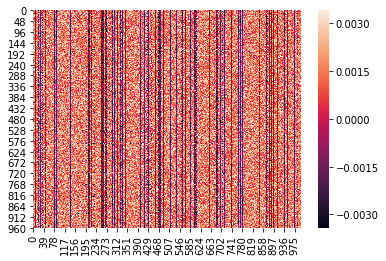

In [23]:
N_NEURONS = 1000
W = np.random.rand(N_NEURONS, N_NEURONS) # Step 1

random_inhib = (np.random.rand(N_NEURONS) <.2) # Step 2
W[:, random_inhib] = -1* W[:, random_inhib] # Step 3

# Step 4
ratio = 1 / N_NEURONS / W.mean()
W = ratio * W 

# Step 5
for i in range(N_NEURONS):
    W[i,i] = 0

sns.heatmap(W)

In [24]:
# Thalamic connections weights
omega = np.ones((N_NEURONS, 1)) * 8 / N_NEURONS

# Main Network object

In [286]:
def sigmoid(x, x0, k):
    return 1. / (1. + np.exp(-k*(x -x0)))

class Network(object):
    def __init__(self, 
                 v0, 
                 W, 
                 omega,
                 history_variables=['v', 's']):
        
        """
        Parameters
        ----------
        
        history_variables: list of string
            Be careful with saving a lot of things.
            It may break RAM (especially saving W)
        """
        self.v = v0
        self.s = np.zeros_like(v0)
        
        self.W0 = W.copy()
        self.W = W
        self.omega0 = omega.copy()
        self.omega = omega 
        self.r = None   
        self.s_thalamus = None  # Thalamic spikes
        
        self.tau_r = 400 # Recovery rate for short term depression
        self.tau_d = 20  # Decay rate for short term depression
        self.leakage = 0.2
        
        self.history_variables = history_variables
        self.history = defaultdict(lambda: [])
        
        
    def spike(self, v, threshold=1):
        s = (v >= np.random.rand(*v.shape)) # Probabilistic spike
        v[s] = 0
        return s, v

    def propagate_spike(self, s):
        nt = self.W @ s
        return nt # Neurotransmitters

    def synapse(self, nt):
        dv = .3 * nt # Delta voltage
        return dv

    def external_input(self):
        self.s_thalamus = (np.random.rand(*self.v.shape) < self.r)
        return self.s_thalamus*omega
    
    def plasticity(self):
        """
        There are two components in each update (equal for both W and omega)
            The recovery component, "homeostatic" (1/self.tau_r) * (self.W0 - self.W)
            The decay component, only when spikes occur (1/self.tau_d) * self.W * self.s 
        """
        self.W = self.W  + (1/self.tau_r) * (self.W0 - self.W) - (1/self.tau_d) * self.W * self.s
        self.omega = self.omega  + (1/self.tau_r) * (self.omega0 - self.omega) - (1/self.tau_d) * self.omega * self.s_thalamus

    def run_simulation(self, r, tmax):
        """
        Parameters
        ----------
        
        r: float, between 0 and 1
            Strenght of talamic input (initialized in simulation)
            It defines the probability that a given thalamic neuron will fire
            
        tmax : integer
            Number of iterations to run the network
        """
        self.r = r
        for t_i in range(tmax):
            self.s, v = self.spike(self.v)
            nt        = self.propagate_spike(self.s)
            ei        = self.external_input()
            dv        = self.synapse(nt) + ei
            self.v    = v + dv - v * self.leakage
            
            self.append_history()
            self.plasticity()

    def append_history(self):
        for var in self.history_variables:
            self.history[var].append(getattr(self, var))
            
    def get_history(self, attr):
        return np.hstack(self.history[attr])
    
    def run_schedule(self, durations, stimulations):
        assert len(durations) == len(stimulations), "Should be same size"
        for tmax, r in zip(durations, stimulations):
            self.run_simulation(r, tmax)

# Run the Network

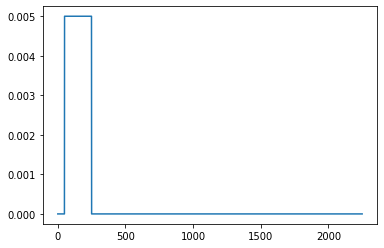

In [306]:
net = Network(v0=np.zeros((N_NEURONS,1)), 
              W=W,
              omega=omega, 
              history_variables=['v', 's', 'r'])

net.run_schedule(durations = [50, 200, 2000], 
                 stimulations = [0, .005, 0])
plt.plot(net.get_history('r'))

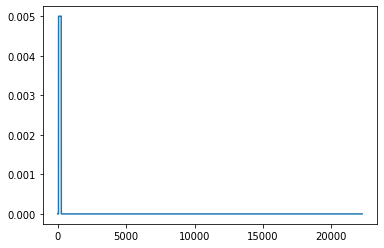

In [307]:
net.run_schedule(durations = [20000], 
                 stimulations = [0])
plt.plot(net.get_history('r'))

Text(0.5, 1, 'Voltage across time for all neurons')

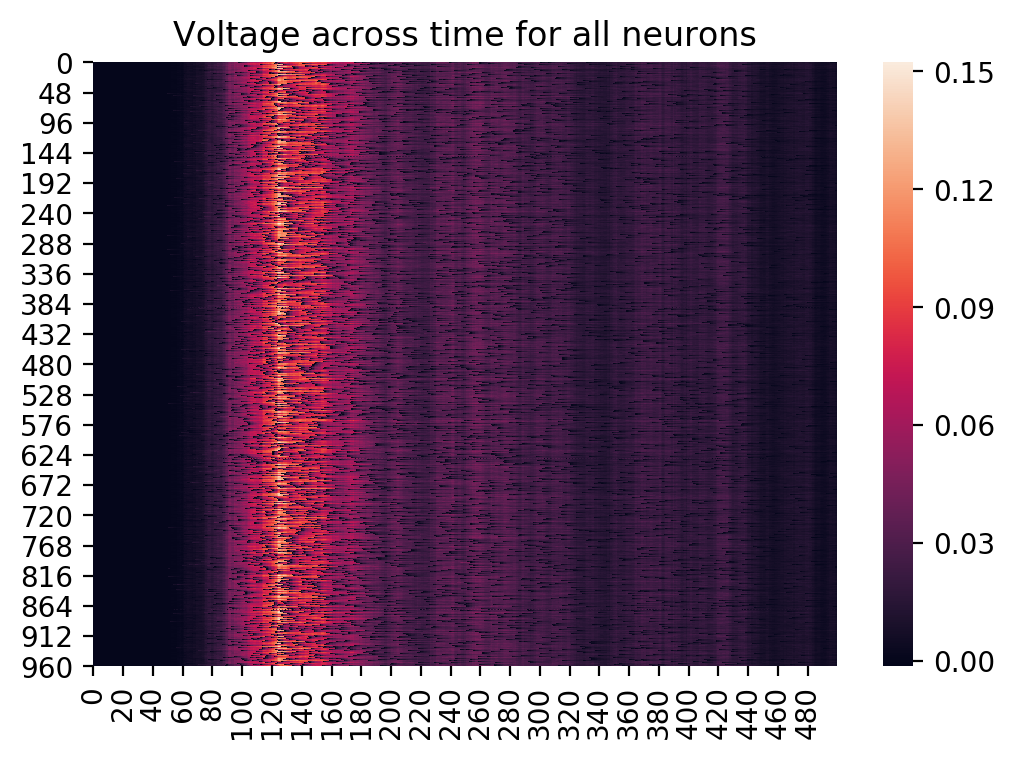

In [308]:
plt.figure(dpi=200)
sns.heatmap(net.get_history('v')[:, :500])
plt.title("Voltage across time for all neurons")

In [309]:
import ipywidgets as wdg

def rasterplot(spike_history, dt, t0=0, ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()
    n, t = np.nonzero(spike_history)
    ax.scatter(t, n, color='k', **kwargs)
    ax.set_yticks([])
    ax.set_xlim(0, spike_history.shape[1])
    
    xticks = ax.get_xticks()
    ax.set_xticklabels((xticks*dt + t0).astype(int))
    return ax

def plot_raster(trange):
    plt.figure(dpi=200)
    rasterplot(net.get_history('s')[:, trange[0]:trange[1]], 1, t0=trange[0], s=0.01)
    sns.despine(left=True)
    plt.title("Spike rasterplot")

wdg.interact_manual(plot_raster, trange = wdg.IntRangeSlider(value= (0,500),
                                                             min=0, 
                                                             max=10000));

interactive(children=(IntRangeSlider(value=(0, 500), description='trange', max=10000), Button(description='Run…

In [310]:
import ipywidgets as wdg

def plot_avg_spk(trange):
    pd.Series(net.get_history('s').sum(axis=0))[trange[0]:trange[1]].plot()
    pd.Series(net.get_history('s').sum(axis=0)).rolling(100).mean(center=True)[trange[0]:trange[1]].plot()
    plt.title("Average firing rate across population")
    
wdg.interact_manual(plot_avg_spk, trange = wdg.IntRangeSlider(min=0, max=10000));

interactive(children=(IntRangeSlider(value=(2500, 7500), description='trange', max=10000), Button(description=…

In [311]:
total_spikes = pd.Series(net.get_history('s').sum(axis=0))
avalanche = total_spikes > 1

In [312]:
event = (avalanche.astype(int).diff().fillna(0)!=0)
event_indexes = event.to_numpy().nonzero()[0]

if len(event_indexes) % 2 == 0:
    avalanche_periods = event_indexes.reshape(-1,2)
else:
    avalanche_periods = event_indexes[:-1].reshape(-1,2)
    
len(event_indexes)

76

In [303]:
avalanche_durations = avalanche_periods[:, 1] - avalanche_periods[:, 0]
spike_sum = net.get_history('s').sum(axis=0)

avalanche_sizes = [spike_sum[avalanche_periods[i][0]: avalanche_periods[i][1]].sum()
                    for i in range(len(avalanche_periods))]

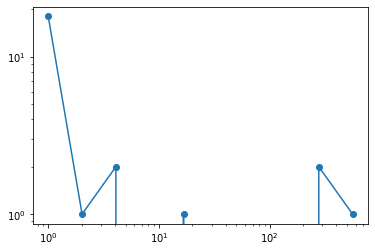

In [304]:
density, bin = np.histogram(np.log10(avalanche_durations), density=False, bins=10)
durations = 10**bin[:-1]

plt.plot(durations, density, marker='o')
plt.yscale('log')
plt.xscale('log')

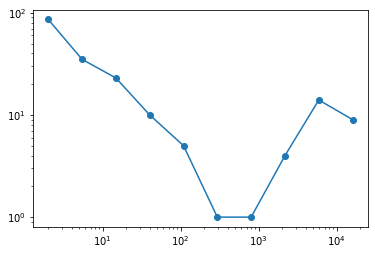

In [653]:
density, bin = np.histogram(np.log10(avalanche_sizes), density=False)
durations = 10**bin[:-1]

plt.plot(durations, density, marker='o')
plt.yscale('log')
plt.xscale('log')

In [667]:
import powerlaw
data = avalanche_sizes # data can be list or numpy array
results = powerlaw.Fit(data)
print(results.power_law.alpha)
print(results.power_law.xmin)

1.4295549833232772
2.0


Calculating best minimal value for power law fit


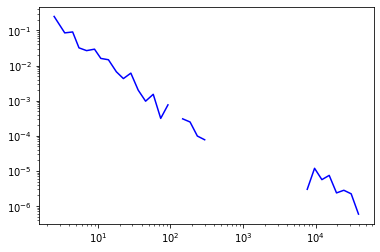

In [670]:
powerlaw.plot_pdf(data, color='b')

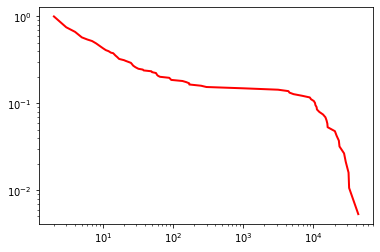

In [671]:
results.plot_ccdf(color='r', linewidth=2)

In [687]:
for distribution in ['lognormal_positive', 
                     'lognormal', 'truncated_power_law']:
    R, p = results.distribution_compare('power_law', distribution)
    print(distribution, R, p)

lognormal_positive 31.890538567232937 2.607914361803839e-11
lognormal -0.02777184159576307 0.6472184600434578
truncated_power_law -0.7025512929037898 0.2358710962730386


Assuming nested distributions


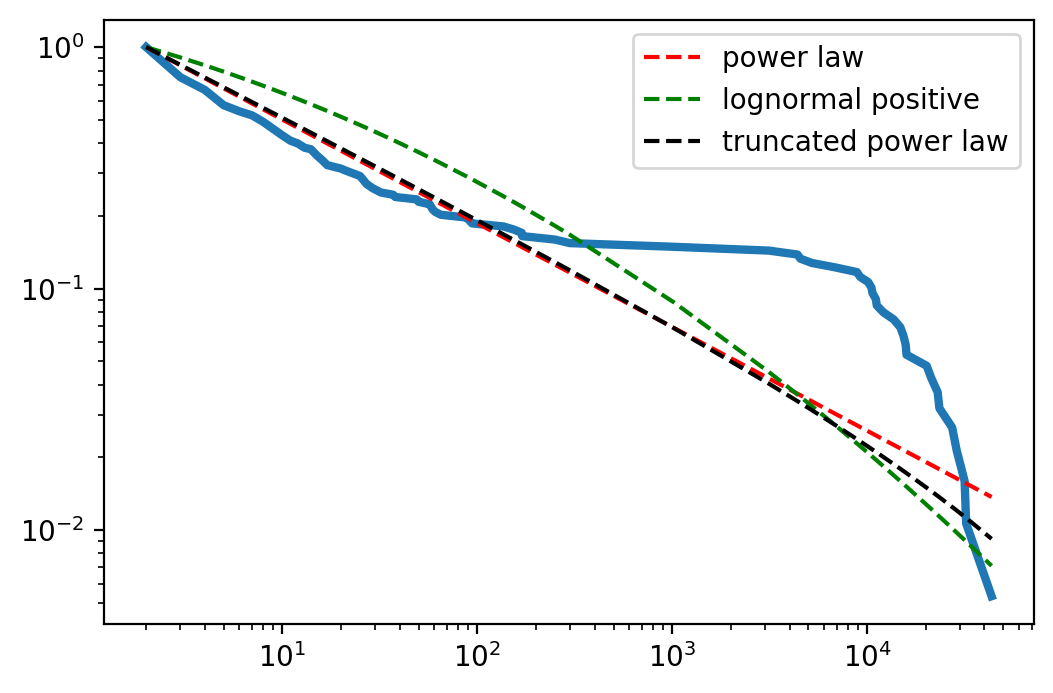

In [704]:
plt.subplots(dpi=200)
fig4=results.plot_ccdf(linewidth=3)
results.power_law.plot_ccdf(ax=fig4, color='r', linestyle='--', label = 'power law')
results.lognormal_positive.plot_ccdf(ax=fig4, color='g', linestyle='--', label = 'lognormal positive')
results.truncated_power_law.plot_ccdf(ax=fig4, color='k', linestyle='--', label = 'truncated power law')

plt.legend()

# Calculate criticality coefficients

## Power spectra

In [654]:
from scipy import fft
from scipy import signal

In [655]:

spectrum = np.vstack([np.abs(np.fft.rfft(sp)) for sp in np.split(spike_sum, 20)]).mean(axis=0)

(0, 1500)

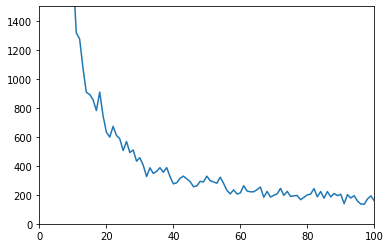

In [656]:
plt.plot(np.abs(spectrum))
plt.xlim(0, 100)
plt.ylim(0, 1500)

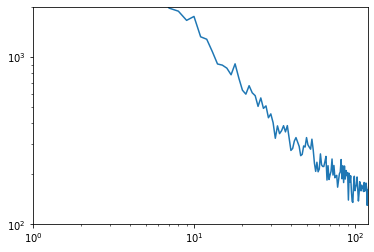

In [657]:
plt.plot(np.abs(spectrum))
plt.xlim(1, 120)
plt.ylim(100, 2000)
plt.yscale('log')
plt.xscale('log')

## Power law

In [658]:
len(avalanche_sizes)

188

In [659]:
q = np.linspace(0,1,1000)
tail_cdf = -1*np.quantile(-np.array(avalanche_sizes), q)

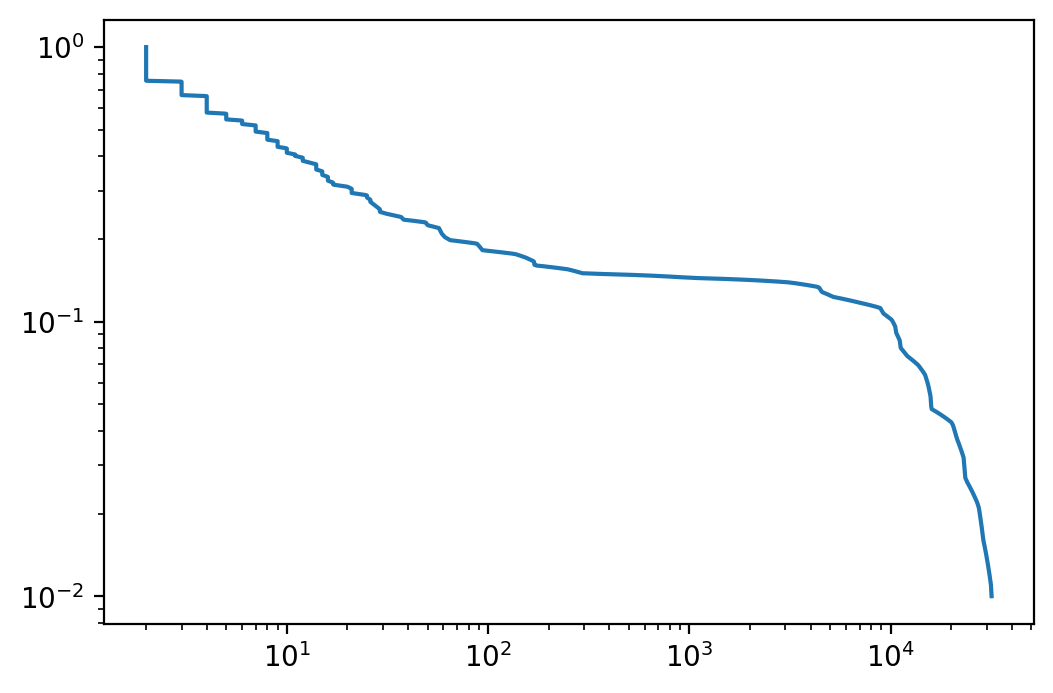

In [660]:
plt.subplots(dpi=200)
plt.plot(tail_cdf[q > .01], q[q > .01])
plt.yscale('log')
plt.xscale('log')

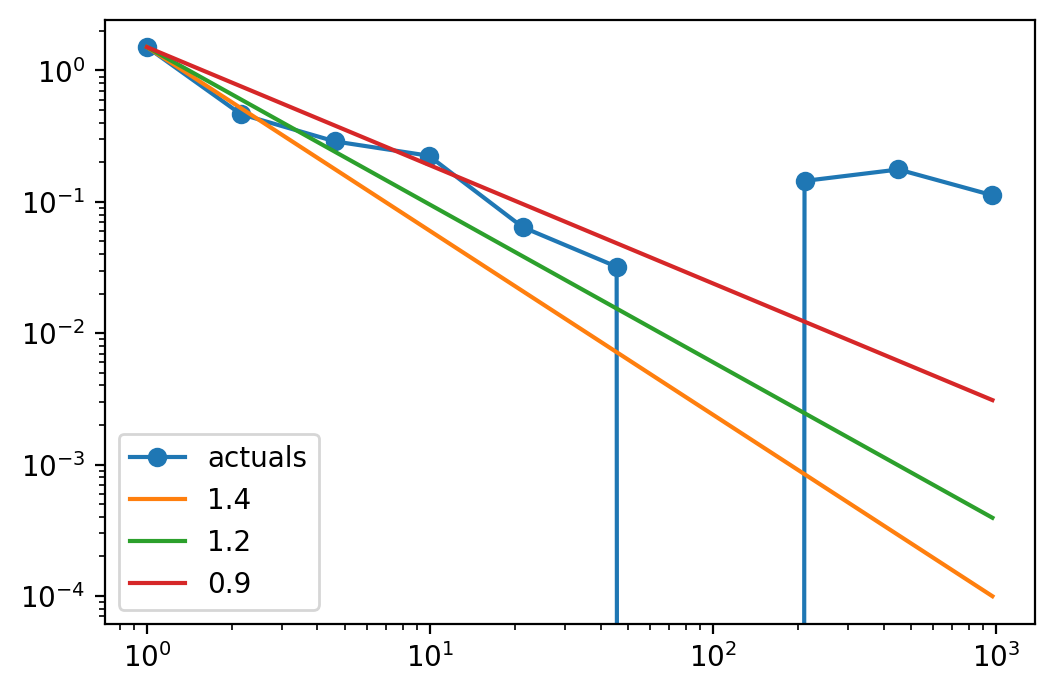

In [672]:
plt.subplots(dpi=200)
density, bin = np.histogram(np.log10(avalanche_durations), density=True, bins=10)
durations = (10**bin[:-1])

C = density[0]/durations[0]

plt.plot(durations, density, marker='o', label='actuals')
plt.plot(durations, C*durations**(-1.4), label='1.4')
plt.plot(durations, C*durations**(-1.2), label='1.2')
plt.plot(durations, C*durations**(-.9), label='0.9')
plt.legend()
plt.yscale('log')
plt.xscale('log')

# Visuals

In [ ]:
spike_history = (np.random.rand(500,2000) > .995).astype(int) # Random "s"
rasterplot(spike_history, 1, s=.1)
sns.despine(left=True)